In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsRegressor

import sys
sys.path.append("..")
from mestrado import datasets
from mestrado.modelling import features

In [3]:
ce_pairs = datasets.load_ce_pairs()
ce_pairs_info = datasets.load_ce_pairs_info()

In [4]:
ce_pairs_info

,sample_id,a_type,b_type,target,details
0,ce_pairs/train1,Numerical,Numerical,0,3
1,ce_pairs/train2,Numerical,Categorical,0,3
2,ce_pairs/train3,Numerical,Binary,1,1
3,ce_pairs/train4,Numerical,Numerical,1,1
4,ce_pairs/train5,Numerical,Numerical,-1,2
...,...,...,...,...,...
5984,ce_pairs_sup/train5985,Binary,Numerical,1,1
5985,ce_pairs_sup/train5986,Categorical,Numerical,0,3
5986,ce_pairs_sup/train5987,Categorical,Numerical,0,4
5987,ce_pairs_sup/train5988,Binary,Binary,0,3


In [9]:
def compute_leakages_knn(ce_pair, n_neighbors=5, n_jobs=1):  
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=n_jobs)

    if ce_pair.b_type == 'Numerical':
        X = ce_pair.data['a'].to_numpy().reshape(-1 ,1)
        y = ce_pair.data['b']
        knn.fit(X, y)
        y_pred = knn.predict(X)
        ce_pair.data['b_cat'] = pd.Categorical(y_pred)
    else:
        ce_pair.data['b_cat'] = ce_pair.data['b']
        
    if ce_pair.a_type == 'Numerical':
        X = ce_pair.data['b'].to_numpy().reshape(-1 ,1)
        y = ce_pair.data['a']
        knn.fit(X, y)
        y_pred = knn.predict(X)
        ce_pair.data['a_cat'] = pd.Categorical(y_pred)
    else:
        ce_pair.data['a_cat'] = ce_pair.data['a']
        
    leakage = features.compute_leakages(ce_pair.data, 'a_cat', 'b_cat')
    leakage['target'] = ce_pair.target
    leakage['details'] = ce_pair.details
    leakage['a_type'] = ce_pair.a_type
    leakage['b_type'] = ce_pair.b_type
    return leakage

In [11]:
# results = []
# for ce_pair in tqdm(ce_pairs):
#     leakage = compute_leakages_knn(ce_pair)
#     results.append(leakage)

In [14]:
results = Parallel(n_jobs=8)(delayed(compute_leakages_knn)(ce_pair) for ce_pair in tqdm(ce_pairs))

  5%|▍         | 632/13820 [01:15<27:36,  7.96it/s]/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
  7%|▋         | 968/13820 [01:44<25:59,  8.24it/s]/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 11%|█         | 1480/13820 [03:07<43:15,  4.76it/s]  /home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 16%|█▌        | 2160/13820 [04:36<17:48, 10.92it/s]/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages

In [15]:
print(len(results))

13820


In [16]:
df_leakages = pd.DataFrame(results)
df_leakages = df_leakages.replace([np.inf, -np.inf], np.nan)

In [18]:
df_leakages.to_parquet("computed_flows_knn.parquet")

In [23]:
df_leakages = pd.read_parquet("computed_flows_knn.parquet")

In [24]:
df_leakages = features.compute_hand_crafted_features(df_leakages)

In [27]:
df_leakages = df_leakages.drop(columns=['reverse_bayes_risk_mult_risk', 'direct_bayes_risk_mult_risk', 'reverse_shannon_mult_leakage', 'direct_shannon_mult_leakage'])

In [28]:
df_leakages = df_leakages.dropna()

In [29]:
df_leakages

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_vuln_add_leakage,reverse_bayes_vuln_add_leakage,direct_bayes_vuln_min_entropy_leakage,reverse_bayes_vuln_min_entropy_leakage,direct_bayes_vuln_mult_capacity,reverse_bayes_vuln_mult_capacity,direct_bayes_vuln_posterior,reverse_bayes_vuln_posterior,...,a_type,b_type,direct_bayes_vuln_mult_leakage_normalized,reverse_bayes_vuln_mult_leakage_normalized,direct_bayes_vuln_mult_leakage_perf,reverse_bayes_vuln_mult_leakage_perf,direct_bayes_vuln_mult_leakage_normalized_perf,reverse_bayes_vuln_mult_leakage_normalized_perf,direct_bayes_vuln_mult_leakage_ratio,reverse_bayes_vuln_mult_leakage_ratio
0,50.500000,73.200000,0.540246,0.492497,5.658211,6.193772,244.933333,248.783333,0.551160,0.499318,...,Numerical,Numerical,62.153846,56.307692,0.002250,0.002007,27620.943590,28055.105128,0.689891,1.449505
1,1.318755,1.318755,0.241709,0.241709,0.399177,0.399177,4.000000,4.000000,1.000000,1.000000,...,Numerical,Categorical,1.318755,1.318755,0.250000,0.250000,5.275021,5.275021,1.000000,1.000000
2,1.453552,1.453552,0.312030,0.312030,0.539583,0.539583,2.000000,2.000000,1.000000,1.000000,...,Numerical,Binary,1.453552,1.453552,0.500000,0.500000,2.907104,2.907104,1.000000,1.000000
3,1.404573,1.231358,0.105852,0.125878,0.490131,0.300250,120.521334,143.245976,0.367490,0.669961,...,Numerical,Numerical,0.912201,1.663008,0.003049,0.004677,299.163672,355.571838,1.140670,0.876678
4,12.666667,10.900000,0.220588,0.103992,3.662965,3.446256,79.236139,92.856275,0.239496,0.114496,...,Numerical,Numerical,16.285714,7.785714,0.003023,0.001233,5388.057472,6314.226711,1.162080,0.860526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13815,1.386412,1.386412,0.278714,0.278714,0.471356,0.471356,2.000000,2.000000,1.000000,1.000000,...,Binary,Numerical,1.386412,1.386412,0.500000,0.500000,2.772824,2.772824,1.000000,1.000000
13816,2.756614,2.756614,0.637236,0.637236,1.462897,1.462897,11.000000,11.000000,1.000000,1.000000,...,Categorical,Numerical,2.756614,2.756614,0.090909,0.090909,30.322751,30.322751,1.000000,1.000000
13817,2.548945,2.548945,0.607681,0.607681,1.349900,1.349900,14.000000,14.000000,1.000000,1.000000,...,Categorical,Numerical,2.548945,2.548945,0.071429,0.071429,35.685232,35.685232,1.000000,1.000000
13818,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.005417,1.012658,0.845238,0.940476,...,Binary,Binary,0.946667,1.053333,0.840684,0.928720,1.126067,1.134177,1.000000,1.000000


In [34]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

In [33]:
estimator = CatBoostClassifier(loss_function='MultiClass', verbose=False)

parameters = {
    'depth':[5, 10, 20],
    'learning_rate':[0.03, 0.1],
    'iterations':[500, 1000],
    'l2_leaf_reg':[1, 3],
}

clf = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='f1_macro', cv=10)

In [35]:
df_train = df_leakages.copy()
df_train['encoded_label'] = df_train['details']

df_X = df_train.drop(columns=['encoded_label', 'details', 'target'])

cat_columns = ['a_type', 'b_type']
cat_columns_idx = [df_X.columns.get_loc(col) for col in cat_columns]

X = df_X.values
y = df_train.encoded_label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [36]:
clf.fit(X_train, y_train, cat_features=cat_columns_idx)

/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felipegiori/anaconda3/envs/ds/lib/python3.9/site-packages/catboost/core.py", line 4768, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/feli

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fe3952918e0>,
             param_grid={'depth': [5, 10, 20], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 3], 'learning_rate': [0.03, 0.1]},
             scoring='f1_macro')

In [37]:
y_pred = clf.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.49      0.40      0.44       345
           2       0.50      0.38      0.43       337
           3       0.46      0.51      0.48       352
           4       0.54      0.71      0.62       346

    accuracy                           0.50      1380
   macro avg       0.50      0.50      0.49      1380
weighted avg       0.50      0.50      0.49      1380



In [5]:
from sklearn.preprocessing import KBinsDiscretizer

In [6]:
ce_pairs_info

,sample_id,a_type,b_type,target,details
0,ce_pairs/train1,Numerical,Numerical,0,3
1,ce_pairs/train2,Numerical,Categorical,0,3
2,ce_pairs/train3,Numerical,Binary,1,1
3,ce_pairs/train4,Numerical,Numerical,1,1
4,ce_pairs/train5,Numerical,Numerical,-1,2
...,...,...,...,...,...
5984,ce_pairs_sup/train5985,Binary,Numerical,1,1
5985,ce_pairs_sup/train5986,Categorical,Numerical,0,3
5986,ce_pairs_sup/train5987,Categorical,Numerical,0,4
5987,ce_pairs_sup/train5988,Binary,Binary,0,3


In [25]:
leakages = []
ce_pair = ce_pairs[3]
for n_bins in range(2, 50):
    kbins = KBinsDiscretizer(n_bins=n_bins+1, encode='ordinal', strategy='uniform')
    if ce_pair.a_type == "Numerical":
        ce_pair.data['a_cat'] = kbins.fit_transform(ce_pair.data['a'].values.reshape(-1, 1))
        cause = 'a_cat'

    if ce_pair.b_type == "Numerical":
        ce_pair.data['b_cat'] = kbins.fit_transform(ce_pair.data['b'].values.reshape(-1, 1))
        effect = 'b_cat'
        
    leakage = features.compute_leakages(ce_pair.data, 'a_cat', 'b_cat')
    leakage['kbins'] = n_bins
    leakages.append(leakage)

In [15]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [26]:
df_leakages = pd.DataFrame(leakages)

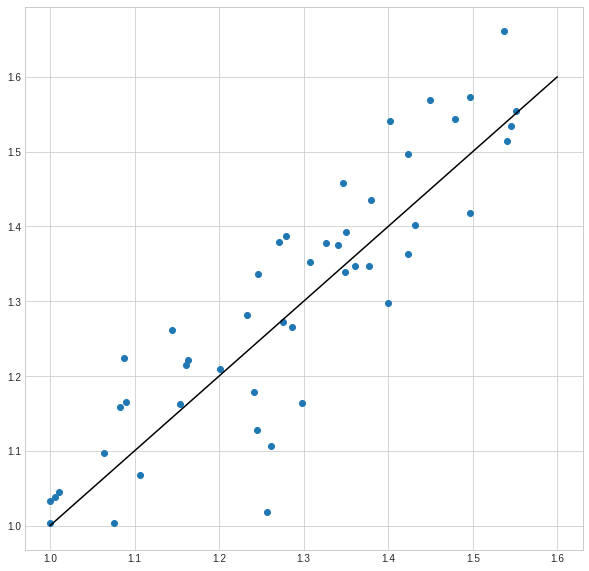

In [21]:
plt.figure(figsize=(10, 10))
line = np.linspace(1, 1.6)
plt.scatter(df_leakages['direct_bayes_vuln_mult_leakage'], df_leakages['reverse_bayes_vuln_mult_leakage'])
plt.plot(line, line, color='black')
plt.show()

In [22]:
import seaborn as sns

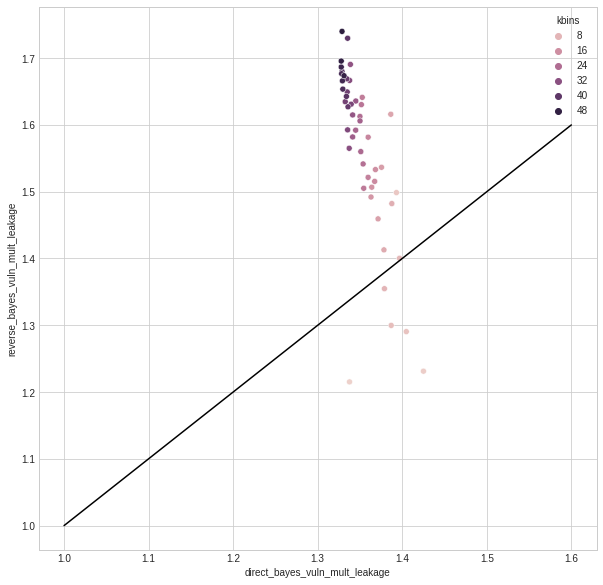

In [27]:
plt.figure(figsize=(10, 10))
line = np.linspace(1, 1.6)
sns.scatterplot(x='direct_bayes_vuln_mult_leakage', y='reverse_bayes_vuln_mult_leakage', data=df_leakages, hue='kbins')
plt.plot(line, line, color='black')
plt.show()

In [33]:
df = pd.read_parquet("computed_flows_kbins.parquet")

In [53]:
ce_pair.data['b'].nunique()

2475

In [40]:
df_causal = df[df['target'] == 1]

In [44]:
df_causal_summary = df_causal.iloc[:, [0, 1, -1]]

In [45]:
df_causal_summary.shape

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,kbins
52,1.020370,1.000000,4
53,1.009091,1.000000,5
54,1.000000,1.000000,6
55,1.000000,1.000000,7
56,1.000000,1.000000,8
...,...,...,...
359211,1.106157,1.207692,25
359212,1.106157,1.256000,26
359213,1.112527,1.285714,27
359214,1.106157,1.271930,28


<AxesSubplot:>

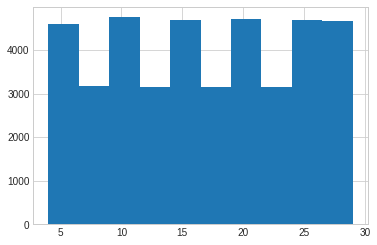

In [48]:
df_causal_summary.query("direct_bayes_vuln_mult_leakage > reverse_bayes_vuln_mult_leakage")['kbins'].hist()

In [50]:
ce_pairs_info.query("target == 1")

,sample_id,a_type,b_type,target,details
2,ce_pairs/train3,Numerical,Binary,1,1
3,ce_pairs/train4,Numerical,Numerical,1,1
14,ce_pairs/train15,Categorical,Categorical,1,1
15,ce_pairs/train16,Numerical,Numerical,1,1
25,ce_pairs/train26,Categorical,Numerical,1,1
...,...,...,...,...,...
5974,ce_pairs_sup/train5975,Numerical,Binary,1,1
5981,ce_pairs_sup/train5982,Numerical,Numerical,1,1
5982,ce_pairs_sup/train5983,Numerical,Binary,1,1
5983,ce_pairs_sup/train5984,Numerical,Numerical,1,1
